In [ ]:
# Fix randomness and hide warnings
seed = 42
input_shape = (96, 96, 3)

import os
os.environ['PYTHONHASHSEED'] = str(seed)

import numpy as np
import math
np.random.seed(seed)
import pandas as pd

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras.applications.convnext import preprocess_input
from tensorflow.keras import layers as tfkl
from tensorflow.keras import regularizers

l2_reg = 0.001

tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Import other libraries
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_class_weight

from google.colab import drive

In [ ]:
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2023-2024] AN2DL/Challenge 1/

Mounted at /gdrive
/gdrive/My Drive/[2023-2024] AN2DL/Challenge 1


# Train Generator Setup

In [ ]:
def load_augmented_batches(batch_dir, preprocess_fn, batch_size):
    batch_files = [os.path.join(batch_dir, file_name) for file_name in os.listdir(batch_dir) if file_name.endswith('.npz')]
    while True:  # Loop indefinitely
        np.random.shuffle(batch_files)  # Shuffle the order of files to introduce randomness
        for batch_file in batch_files:
            # Load the entire batch file
            batch_data = np.load(batch_file)
            images = batch_data['data']
            labels = batch_data['labels']

            # Shuffle the data
            indices = np.arange(len(images))
            np.random.shuffle(indices)
            images = images[indices]
            labels = labels[indices]

            # Yield batches from the current file
            for i in range(0, len(images), batch_size):
                end_index = i + batch_size if (i + batch_size) < len(images) else len(images)
                batch_images = images[i:end_index]
                batch_labels = labels[i:end_index]
                yield preprocess_fn(batch_images), batch_labels



# ConvNeXt Model

In [ ]:
convnext = tfk.applications.ConvNeXtBase(
      input_shape = input_shape,
      include_top = False,
      pooling='avg'
  )

#convnext.trainable = False

785596384/785596384 [==============================] - 3s 0us/step


In [ ]:
inputs = tfk.Input(shape=input_shape)

x = convnext(inputs)

x = tfkl.Dense(
    10,
    activation='gelu',
    kernel_regularizer=tfk.regularizers.l2(1e-4),
    name="c_dense0")(x)
x = tfkl.Dropout(0.3, name="drop0")(x)


outputs = tfkl.Dense(1, activation='sigmoid', name="c_output")(x)

model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Define a learning rate schedule
lr_schedule = tfk.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,  # Start with this learning rate
    decay_steps=900,           # After how many steps to apply decay
    decay_rate=0.9,              # Decay rate
    staircase=True)              # If True, learning rate is reduced at discrete intervals

# Define the optimizer with the schedule (Adam for custom weight decay)
optimizer = tfk.optimizers.Adam(learning_rate=lr_schedule)

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',          # Monitor validation accuracy
    mode='max',                  # Mode 'max' because we want to maximize accuracy
    patience=13,                  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True)   # Restore model weights from the epoch with the best value of the monitored quantity

reduce_lr_on_plateau = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5
    )

callbacks = [early_stopping, reduce_lr_on_plateau]

model.compile(
    loss=tfk.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy']
)
model.summary()

# Train (Generators)


In [ ]:
train_dir = 'Data/Augmented_Experimental/Train/'
val_dir = 'Data/Augmented_Experimental/Validation/'

npz_file_size = 5000
batch_size = 32

train_generator = load_augmented_batches(train_dir, preprocess_input, batch_size)
val_generator = load_augmented_batches(val_dir, preprocess_input, batch_size)


# Determine the number of steps per epoch (number of batches)
train_steps = sum(1 for _ in os.listdir(train_dir) if _.endswith('.npz')) * (npz_file_size // batch_size)
val_steps = sum(1 for _ in os.listdir(val_dir) if _.endswith('.npz')) * (npz_file_size // batch_size)

In [ ]:
history = model.fit(
    x = train_generator,  # Training data comes from the generator
    steps_per_epoch = train_steps,  # Number of batches in the training set
    epochs = 700,
    validation_data = val_generator,  # Validation data comes from the generator
    validation_steps = val_steps,  # Number of batches in the validation set
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=7, restore_best_weights=True)]
).history

Epoch 1/700
1092/1092 [==============================] - 322s 263ms/step - loss: 0.3856 - accuracy: 0.8227 - val_loss: 0.3284 - val_accuracy: 0.8559
Epoch 2/700
1092/1092 [==============================] - 239s 219ms/step - loss: 0.2905 - accuracy: 0.8740 - val_loss: 0.3055 - val_accuracy: 0.8734
Epoch 3/700
1092/1092 [==============================] - 237s 217ms/step - loss: 0.2593 - accuracy: 0.8882 - val_loss: 0.2920 - val_accuracy: 0.8732
Epoch 4/700
1092/1092 [==============================] - 203s 186ms/step - loss: 0.2301 - accuracy: 0.9027 - val_loss: 0.3073 - val_accuracy: 0.8768
Epoch 5/700
1092/1092 [==============================] - 198s 181ms/step - loss: 0.2207 - accuracy: 0.9065 - val_loss: 0.2937 - val_accuracy: 0.8837
Epoch 6/700
1092/1092 [==============================] - 204s 187ms/step - loss: 0.1978 - accuracy: 0.9175 - val_loss: 0.3346 - val_accuracy: 0.8707
Epoch 7/700
1092/1092 [==============================] - 208s 190ms/step - loss: 0.1881 - accuracy: 0.9213

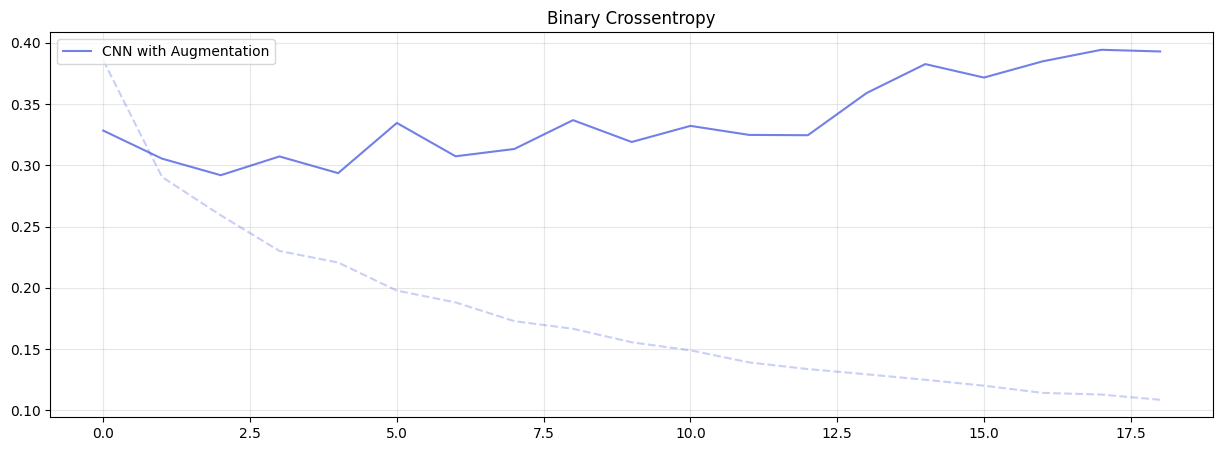

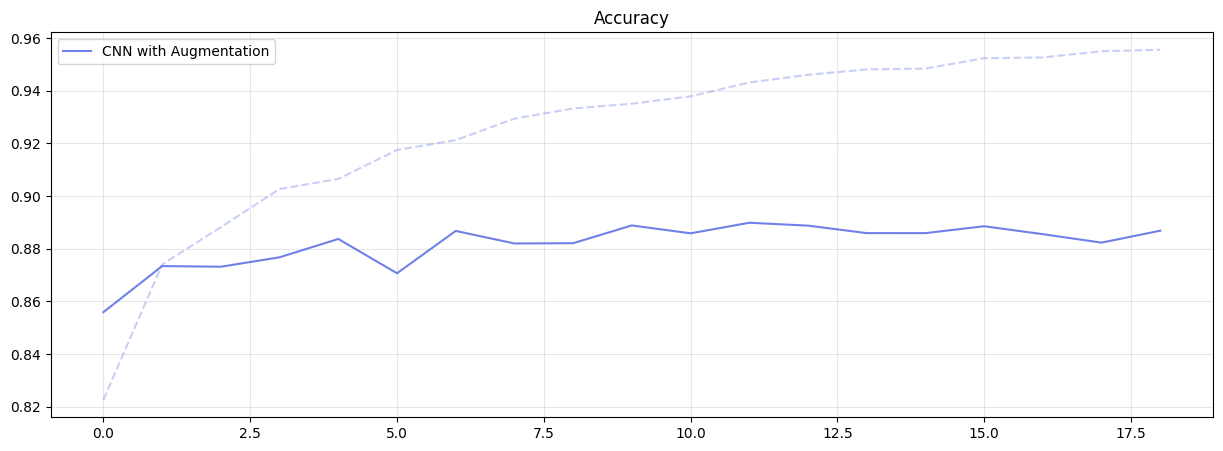

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='CNN with Augmentation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='CNN with Augmentation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## Manual Evaluation

In [ ]:
data = np.load('Data/Augmented/train_balanced.npz', allow_pickle=True)
X_test, y_test = data["data"], data["labels"]

In [ ]:
model.evaluate(X_test, y_test)

156/156 [==============================] - 26s 164ms/step - loss: 0.2199 - accuracy: 0.9083


[0.21988864243030548, 0.9082697629928589]

# Train (Manual)

In [ ]:
train = np.load('Data/Augmented_Unbalanced/Train/13k.npz', allow_pickle=True)
X_train, y_train = train["data"], train["labels"]

## Calculate class weights

In [ ]:
class_weights = compute_class_weight(
    'balanced',
    classes = np.unique(y_train),
    y = y_train
)

class_weight_dict = dict(enumerate(class_weights))

## Training

In [ ]:
val = np.load('Data/Augmented_Unbalanced/Validation/valid_13k.npz', allow_pickle=True)
X_val, y_val = val["data"], val["labels"]

In [ ]:
history = model.fit(
    X_train,
    y_train,
    class_weight = class_weight_dict,
    validation_data=(X_val, y_val),
    epochs = 65,
    callbacks = callbacks
).history

Epoch 1/65
376/376 [==============================] - 133s 264ms/step - loss: 0.5225 - accuracy: 0.7509 - val_loss: 0.4904 - val_accuracy: 0.7762 - lr: 0.0010
Epoch 2/65
376/376 [==============================] - 91s 241ms/step - loss: 0.4393 - accuracy: 0.8305 - val_loss: 0.3899 - val_accuracy: 0.8442 - lr: 0.0010
Epoch 3/65
376/376 [==============================] - 91s 242ms/step - loss: 0.3798 - accuracy: 0.8436 - val_loss: 0.3382 - val_accuracy: 0.8651 - lr: 9.0000e-04
Epoch 4/65
376/376 [==============================] - 90s 240ms/step - loss: 0.3407 - accuracy: 0.8559 - val_loss: 0.3091 - val_accuracy: 0.8771 - lr: 9.0000e-04
Epoch 5/65
376/376 [==============================] - 86s 228ms/step - loss: 0.3258 - accuracy: 0.8602 - val_loss: 0.2939 - val_accuracy: 0.8851 - lr: 8.1000e-04
Epoch 6/65
376/376 [==============================] - 86s 228ms/step - loss: 0.3091 - accuracy: 0.8714 - val_loss: 0.2859 - val_accuracy: 0.8821 - lr: 8.1000e-04
Epoch 7/65
376/376 [===============

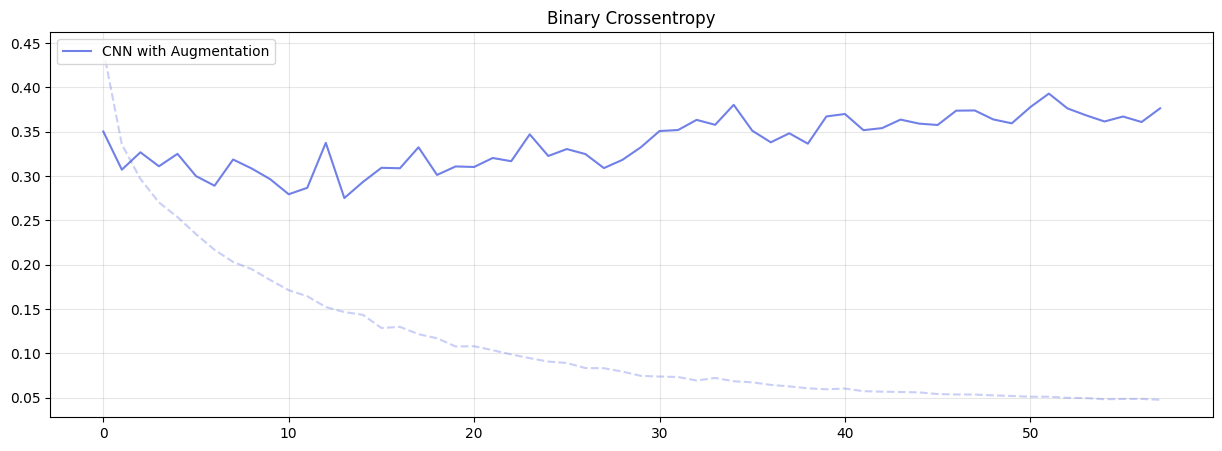

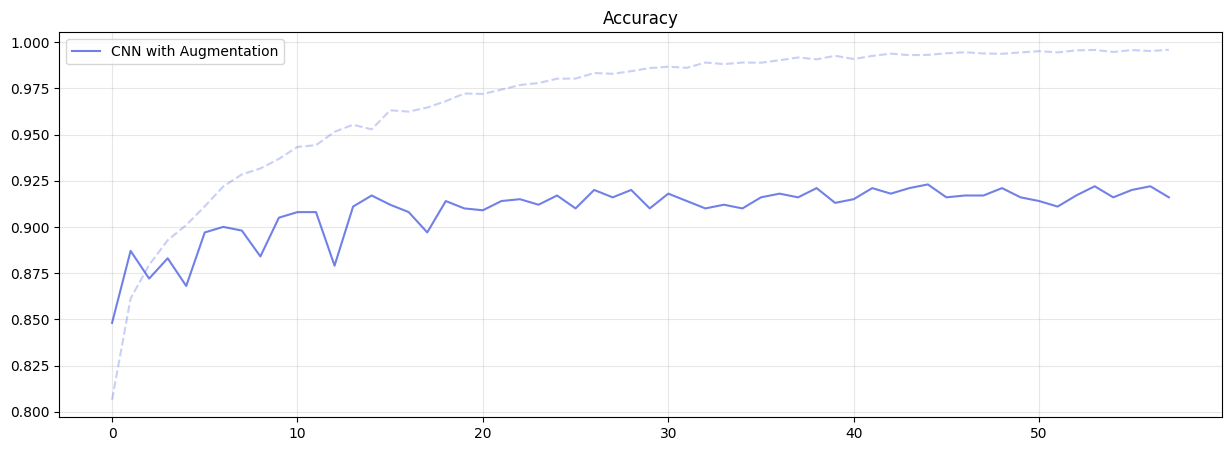

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='CNN with Augmentation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='CNN with Augmentation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Saving

In [ ]:
model.save("Models/Convnext_unbal_noweighting")

In [ ]:
# Testing if save was successful
m1 = tf.keras.models.load_model('Convnext')